<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
%matplotlib inline

from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv("/content/movies_train.csv")
test = pd.read_csv("/content/movies_test.csv")
sub = pd.read_csv("/content/submission.csv")

In [3]:
# 결측치 처리
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

# release_year, release_month 데이터 생성
train['release_time']=pd.to_datetime(train['release_time']) # dt method 사용을 위해 날짜 형식으로 변환
test['release_time']=pd.to_datetime(test['release_time'])
train['release_year']=pd.to_numeric(train['release_time'].dt.year)
test['release_year']=pd.to_numeric(test['release_time'].dt.year)
train['release_month']=pd.to_numeric(train['release_time'].dt.month)
test['release_month']=pd.to_numeric(test['release_time'].dt.month)

# 불필요한 피처 제거
train=train.drop(['title','director','release_time'], axis=1)
test=test.drop(['title','director','release_time'], axis=1)

# train 데이터 'dir_prev_bfnum' 이상치 삭제
train = train.sort_values(by='dir_prev_bfnum', ascending=False).iloc[1:]

# test 데이터 'time' 이상치 삭제
test.sort_values(by='time', ascending=False)[0]=63

In [4]:
# 중복 distributor 처리
def distr_preprocessing(x) :
    if 'CGV' in x or '무비꼴라쥬' in x :
        return 'CGV'
    elif 'E&M' in x or 'CJ엔터테인먼트' in x or 'CJ 엔터테인먼트' in x:
        return 'CJ E&M'
    elif '롯데' in x :
        return '롯데엔터테인먼트'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x or 'KT' in x:
        return '싸이더스'
    elif '마운틴' in x:
        return '마운틴픽쳐스'
    elif '메가박스' in x or '씨너스' in x:
        return '메가박스플러스엠'
    elif '쇼박스' in x or '(주)쇼박스' in x :
        return '쇼박스'
    elif '조이앤시네마' in x or '조이앤컨텐츠그룹' in x or '(주) 케이알씨지' in x or '드림팩트' in x:
        return '조이앤'
    elif '타임스토리' in x :
        return '타임스토리'
    elif '프리비젼' in x :
        return '프리비젼'
    elif '리틀빅픽' in x :
        return '리틀빅픽쳐스'
    elif '콘텐츠판다' in x or 'NEW' in x:
        return 'NEW'
    elif 'SK' in x:
        return 'SK'
    elif '마인스' in x:
        return '마인스'
    elif '에이원' in x:
        return '에이원'
    elif 'THE 픽쳐스' in x or '더픽쳐스' in x:
        return '더픽쳐스'
    elif '시네마 달' in x or '(주)시네마달' in x:
        return '시네마달'
    elif '와이드 릴리즈' in x or '와이드릴리즈' in x:
        return '와이드릴리즈'
    else :
        return x

train['distributor']=train['distributor'].apply(distr_preprocessing)
test['distributor']=test['distributor'].apply(distr_preprocessing)

In [5]:
# 상위 14개 배급사를 제외한 배급사는 '기타'로 처리
dist_train=train.distributor.value_counts()[:14]

def distributor_etc(x):
  if x in dist_train:
    return x
  else:
    return('기타')

train['distributor']=train['distributor'].apply(distributor_etc).apply(lambda x : distributor_etc(x))

dist_test = dist_train.index.tolist()
test['distributor'] = test['distributor'].apply(lambda x : x if x in dist_test else '기타')

In [6]:
# 관객수 log 변환 데이터 생성
import numpy as np

train_log=train.copy()
train_log['box_off_num']=np.log1p(train_log['box_off_num'])

In [7]:
# 원핫인코딩
train=pd.get_dummies(train, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)
train_log=pd.get_dummies(train_log, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)
test=pd.get_dummies(test, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)

train=train.astype(int)
train_log=train_log.astype(int)
test=test.astype(int)

In [8]:
y_train=train['box_off_num']
X_train=train.drop(['box_off_num'], axis=1, inplace=False)

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm = MinMaxScaler()
X_train_mm = X_train.copy()
X_train_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = mm.fit_transform(X_train_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])
X_test_mm = test.copy()
X_test_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = mm.transform(X_test_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])

ss = StandardScaler()
X_train_ss = X_train.copy()
X_train_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = ss.fit_transform(X_train_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])
X_test_ss = test.copy()
X_test_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = ss.transform(X_test_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])


In [10]:
### 모델링을 위한 함수
# Observed vs Fitted 시각화
# 평가 지표 시각화

my_predictions = {} # 빈 딕셔너리

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato']

def plot_predictions(name_, pred, actual): # parameter: 모델명, 예측값, 실제값
  df = pd.DataFrame({'prediction' : pred,'actual': y_valid})
  df = df.sort_values(by = 'actual').reset_index(drop = True)

  plt.figure(figsize = (12,9))
  plt.scatter(df.index,df['prediction'],marker = 'x',color = 'r')
  plt.scatter(df.index,df['actual'],alpha = 0.7,marker = 'o',color = 'black')
  plt.title(name_,fontsize = 15)
  plt.legend(['prediction','actual'],fontsize = 12)
  plt.show()

def rmse_eval(name_,pred,actual):
  global my_predictions
  global colors

  plot_predictions(name_, pred, actual)

  rmse = np.sqrt(mean_squared_error(pred,actual))
  my_predictions[name_] = rmse

  y_value = sorted(my_predictions.items(),key = lambda x: x[1],reverse = True) # 내림차순 정렬

  df = pd.DataFrame(y_value, columns = ['model','rmse'])
  print(df)

  # 상한, 하한 설정
  min_ = df['rmse'].min() - 10
  max_ = df['rmse'].max() + 10

  length = len(df)

  plt.figure(figsize = (10,length))
  ax = plt.subplot() # subplot 객체
  ax.set_yticks(np.arange(len(df)))
  ax.set_yticklabels(df['model'],fontsize = 15)
  bars = ax.barh(np.arange(len(df)),df['rmse'])

  for i,v in enumerate(df['rmse']): # 인덱스, value
    idx = np.random.choice(len(colors))
    bars[i].set_color(colors[idx])
    ax.text(v + 2,i,str(round(v,5)),color = 'k',fontsize = 15,fontweight = 'bold')

  plt.title('RMSE Error',fontsize = 18)
  plt.xlim(min_,max_)

  plt.show()

In [11]:
X_train_mm, X_valid_mm, y_train, y_valid = train_test_split(X_train_mm, y_train, test_size = 0.2, random_state = 0)

# 회귀 트리

### 1) 결정 트리 (Decision Tree)

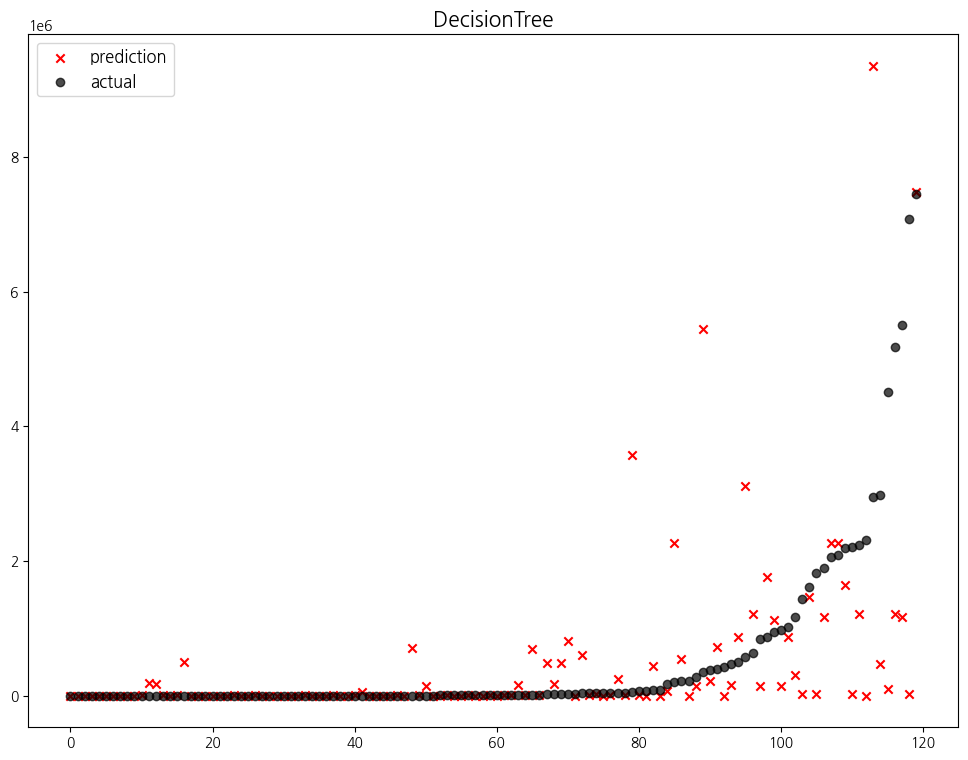

          model          rmse
0  DecisionTree  1.366686e+06


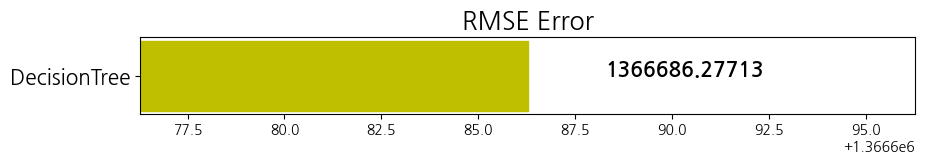

In [12]:
dt = DecisionTreeRegressor()
dt.fit(X_train_mm, y_train)
dt_pred = dt.predict(X_valid_mm)
rmse_eval('DecisionTree',dt_pred,y_valid)

### 2) 랜덤 포레스트 (Random Forest)

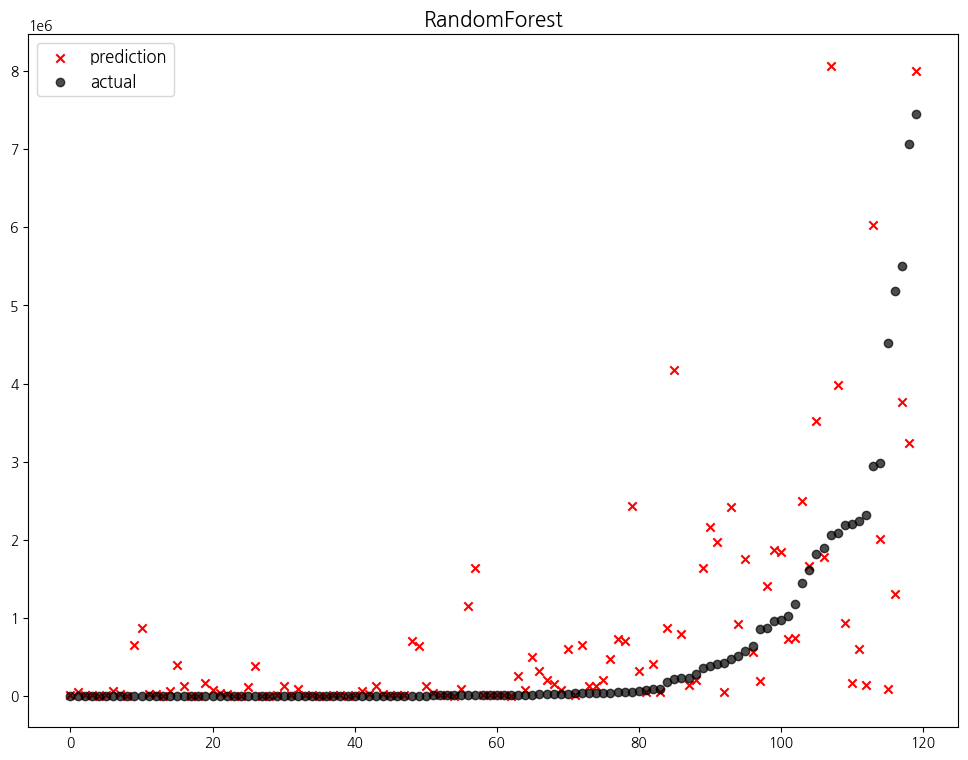

          model          rmse
0  DecisionTree  1.366686e+06
1  RandomForest  1.178189e+06


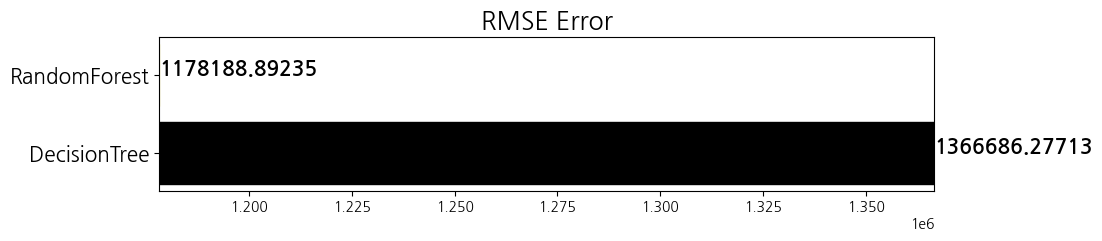

In [13]:
rfr = RandomForestRegressor()
rfr.fit(X_train_mm,y_train)
rfr_pred = rfr.predict(X_valid_mm)
rmse_eval('RandomForest',rfr_pred,y_valid)

### 제출

In [14]:
dt_final = dt.predict(X_test_mm)
dt_final = np.round(dt_final)
dt_final = pd.DataFrame(dt_final)
dt_final.head()

,0
0,2971475.0
1,1755181.0
2,1166025.0
3,6178665.0
4,1025243.0


In [15]:
sub['box_off_num'] = dt_final
sub.head(10)

,title,box_off_num
0,용서는 없다,2971475.0
1,아빠가 여자를 좋아해,1755181.0
2,하모니,1166025.0
3,의형제,6178665.0
4,평행 이론,1025243.0
5,회오리 바람,142170.0
6,경계도시 2,2972.0
7,이웃집 남자,1217.0
8,아마존의 눈물 극장판,155281.0
9,반가운 살인자,700272.0


In [16]:
sub.to_csv('dt_final_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1650610.2677087325

In [17]:
rfr_final = rfr.predict(X_test_mm)
rfr_final = np.round(rfr_final)
rfr_final = pd.DataFrame(rfr_final)
rfr_final.head()

,0
0,1955540.0
1,1710578.0
2,1663370.0
3,2352773.0
4,934854.0


In [18]:
sub['box_off_num'] = rfr_final
sub.head(10)

,title,box_off_num
0,용서는 없다,1955540.0
1,아빠가 여자를 좋아해,1710578.0
2,하모니,1663370.0
3,의형제,2352773.0
4,평행 이론,934854.0
5,회오리 바람,55954.0
6,경계도시 2,7968.0
7,이웃집 남자,1855.0
8,아마존의 눈물 극장판,58257.0
9,반가운 살인자,372003.0


In [19]:
sub.to_csv('rfr_final_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1315287.8531292712

최적 하이퍼 파라미터:
 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2}
최고 예측 RMSE: 1512738.4422


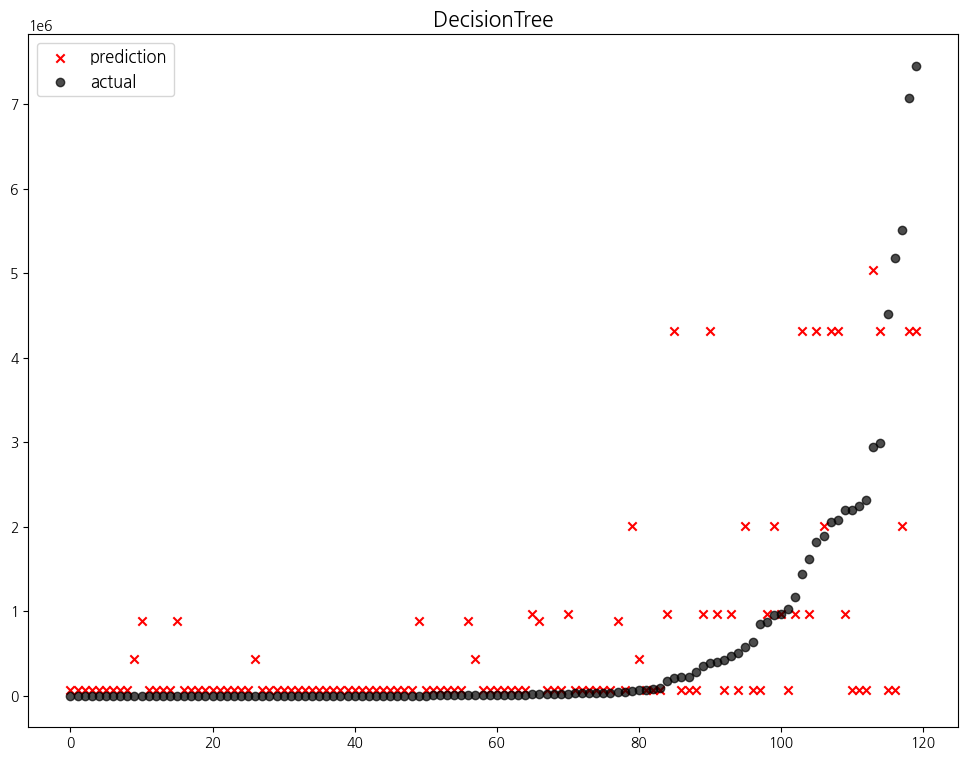

          model          rmse
0  DecisionTree  1.201465e+06
1  RandomForest  1.178189e+06


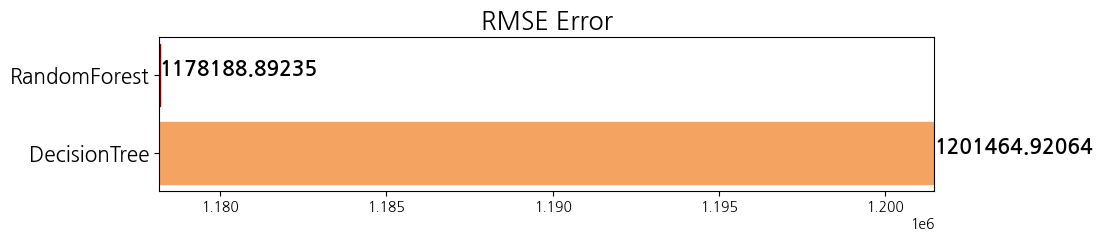

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

dt = DecisionTreeRegressor()
grid_dt = GridSearchCV(dt, param_grid=param_grid, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1, refit=True)
grid_dt.fit(X_train_mm, y_train)

print('최적 하이퍼 파라미터:\n', grid_dt.best_params_)
print('최고 예측 RMSE: {0:.4f}'.format(-1* grid_dt.best_score_))

best_dt = grid_dt.best_estimator_
dt_pred = best_dt.predict(X_valid_mm)

rmse_eval('DecisionTree', dt_pred, y_valid)

dt_grid_final = best_dt.predict(X_test_mm)
dt_grid_final = np.round(dt_grid_final)
dt_grid_final = pd.DataFrame(dt_grid_final)
dt_grid_final.head()

sub['box_off_num'] = dt_grid_final
sub.to_csv('dt_grid_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1510091.193622741

최적 하이퍼 파라미터:
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
최고 예측 RMSE: 1423051.4200


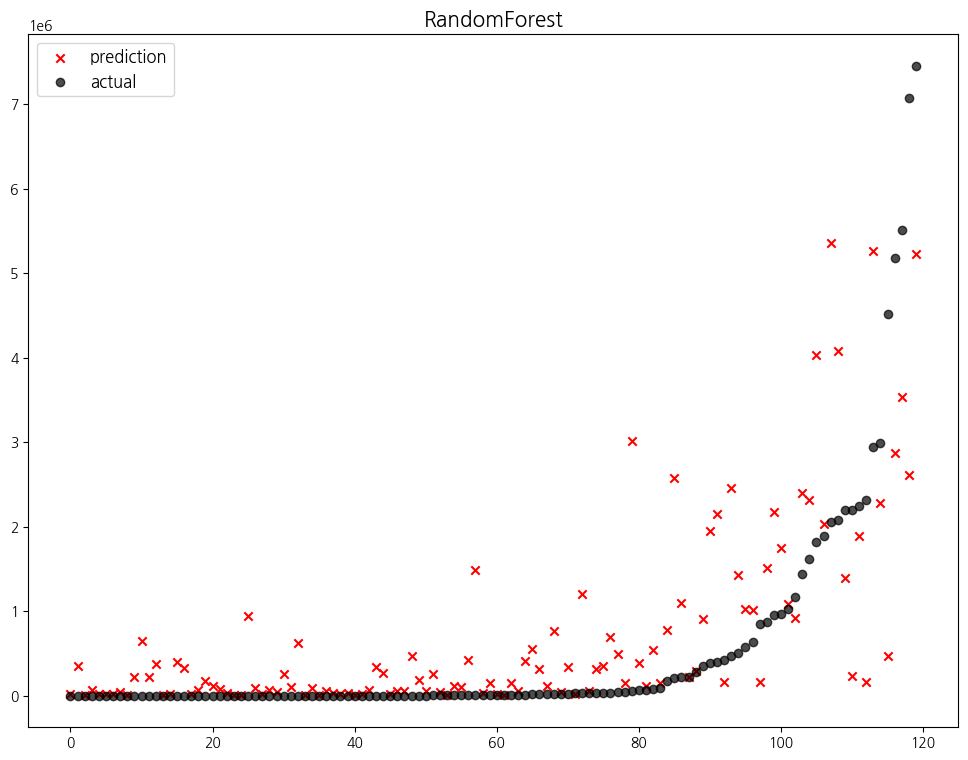

          model          rmse
0  DecisionTree  1.201465e+06
1  RandomForest  1.022298e+06


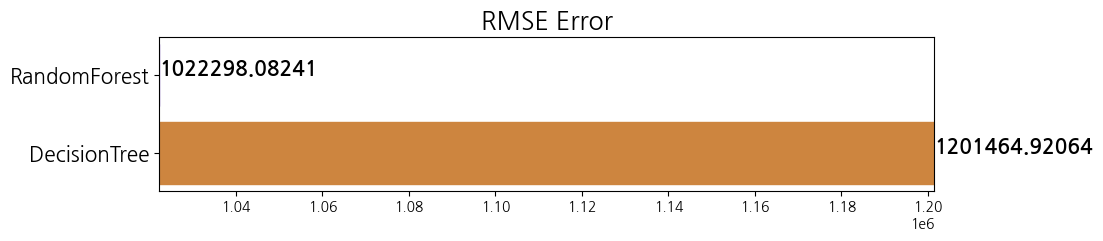

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(rfr, param_grid=param_grid, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1, refit=True)
grid_rfr.fit(X_train_mm, y_train)

print('최적 하이퍼 파라미터:\n', grid_rfr.best_params_)
print('최고 예측 RMSE: {0:.4f}'.format(-1* grid_rfr.best_score_))

best_rfr = grid_rfr.best_estimator_
rfr_pred = best_rfr.predict(X_valid_mm)

rmse_eval('RandomForest', rfr_pred, y_valid)

rfr_grid_final = best_rfr.predict(X_test_mm)
rfr_grid_final = np.round(rfr_grid_final)
rfr_grid_final = pd.DataFrame(rfr_grid_final)
rfr_grid_final.head()

sub['box_off_num'] = rfr_grid_final
sub.to_csv('rfr_grid_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1349128.928032488